In [1]:
import numpy as np
import matplotlib.pyplot as plt

4.5 計算例

4.5.2 オルスザッグ・タングの渦問題 \
使用スキーム：HLLD法・MUSCL(minmod)・中点法 

In [2]:
def minmod(x, y):
    return np.sign(x) * np.maximum(0, np.minimum(np.abs(x), np.sign(x)*y))


def get_L_component(rho, u, v, w, Bx, By, Bz, e, axis):
    rho_L = rho + 1/2 * minmod(rho - np.roll(rho, 1, axis=axis), np.roll(rho, -1, axis=axis) - rho)
    u_L = u + 1/2 * minmod(u - np.roll(u, 1, axis=axis), np.roll(u, -1, axis=axis) - u)
    v_L = v + 1/2 * minmod(v - np.roll(v, 1, axis=axis), np.roll(v, -1, axis=axis) - v)
    w_L = w + 1/2 * minmod(w - np.roll(w, 1, axis=axis), np.roll(w, -1, axis=axis) - w)
    Bx_L = Bx + 1/2 * minmod(Bx - np.roll(Bx, 1, axis=axis), np.roll(Bx, -1, axis=axis) - Bx)
    By_L = By + 1/2 * minmod(By - np.roll(By, 1, axis=axis), np.roll(By, -1, axis=axis) - By)
    Bz_L = Bz + 1/2 * minmod(Bz - np.roll(Bz, 1, axis=axis), np.roll(Bz, -1, axis=axis) - Bz)
    e_L = e + 1/2 * minmod(e - np.roll(e, 1, axis=axis), np.roll(e, -1, axis=axis) - e)

    return rho_L, u_L, v_L, w_L, Bx_L, By_L, Bz_L, e_L


def get_R_component(rho, u, v, w, Bx, By, Bz, e, axis):
    rho_R = np.roll(rho, -1, axis=axis) - 1/2 * minmod(np.roll(rho, -1, axis=axis) - rho, np.roll(rho, -2, axis=axis) - np.roll(rho, -1, axis=axis))
    u_R = np.roll(u, -1, axis=axis) - 1/2 * minmod(np.roll(u, -1, axis=axis) - u, np.roll(u, -2, axis=axis) - np.roll(u, -1, axis=axis))
    v_R = np.roll(v, -1, axis=axis) - 1/2 * minmod(np.roll(v, -1, axis=axis) - v, np.roll(v, -2, axis=axis) - np.roll(v, -1, axis=axis))
    w_R = np.roll(w, -1, axis=axis) - 1/2 * minmod(np.roll(w, -1, axis=axis) - w, np.roll(w, -2, axis=axis) - np.roll(w, -1, axis=axis))
    Bx_R = np.roll(Bx, -1, axis=axis) - 1/2 * minmod(np.roll(Bx, -1, axis=axis) - Bx, np.roll(Bx, -2, axis=axis) - np.roll(Bx, -1, axis=axis))
    By_R = np.roll(By, -1, axis=axis) - 1/2 * minmod(np.roll(By, -1, axis=axis) - By, np.roll(By, -2, axis=axis) - np.roll(By, -1, axis=axis))
    Bz_R = np.roll(Bz, -1, axis=axis) - 1/2 * minmod(np.roll(Bz, -1, axis=axis) - Bz, np.roll(Bz, -2, axis=axis) - np.roll(Bz, -1, axis=axis))
    e_R = np.roll(e, -1, axis=axis) - 1/2 * minmod(np.roll(e, -1, axis=axis) - e, np.roll(e, -2, axis=axis) - np.roll(e, -1, axis=axis))
    
    return rho_R, u_R, v_R, w_R, Bx_R, By_R, Bz_R, e_R


def get_U_parameters_1(rho, u, v, w, Bx, By, Bz, e, pT, pT_1, S, SM):
    rho1 = rho * (S - u) / (S - SM)
    u1 = SM
    v1 = v - Bx * By * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2)
    w1 = w - Bx * Bz * (SM - u) / (rho * (S - u) * (S - SM) - Bx**2)
    Bx1 = Bx
    By1 = By * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2)
    Bz1 = Bz * (rho * (S - u)**2 - Bx**2) / (rho * (S - u) * (S - SM) - Bx**2)
    e1 = ((S - u) * e - pT * u + pT_1 * SM + Bx * ((u*Bx + v*By + w*Bz) - (u1*Bx1 + v1*By1 + w1*Bz1))) / (S - SM)
    
    return rho1, u1, v1, w1, Bx1, By1, Bz1, e1


def get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx1_L, Bx1_R, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM):
    u2 = SM
    v2 = (np.sqrt(rho1_L)*v1_L + np.sqrt(rho1_R)*v1_R + (By1_R - By1_L)*np.sign(Bx1_L)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    w2 = (np.sqrt(rho1_L)*w1_L + np.sqrt(rho1_R)*w1_R + (Bz1_R - Bz1_L)*np.sign(Bx1_R)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    Bx2 = Bx1_L
    By2 = (np.sqrt(rho1_L)*By1_R + np.sqrt(rho1_R)*By1_L + np.sqrt(rho1_L*rho1_R)*(v1_R - v1_L)*np.sign(Bx1_L)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    Bz2 = (np.sqrt(rho1_L)*Bz1_R + np.sqrt(rho1_R)*Bz1_L + np.sqrt(rho1_L*rho1_R)*(w1_R - w1_L)*np.sign(Bx1_R)) / (np.sqrt(rho1_L) + np.sqrt(rho1_R))
    e2_L = e1_L - np.sqrt(rho1_L) * ((u1_L*Bx1_L + v1_L*By1_L + w1_L*Bz1_L) - (u2*Bx2 + v2*By2 + w2*Bz2)) * np.sign(Bx2)
    e2_R = e1_R + np.sqrt(rho1_R) * ((u1_R*Bx1_R + v1_R*By1_R + w1_R*Bz1_R) - (u2*Bx2 + v2*By2 + w2*Bz2)) * np.sign(Bx2)

    return u2, v2, w2, Bx2, By2, Bz2, e2_L, e2_R


def get_flux(rho, u, v, w, Bx, By, Bz, e, pT, F):
    F[0, :, :] = rho * u
    F[1, :, :] = rho * u**2 + pT - Bx**2
    F[2, :, :] = rho * u * v - Bx * By
    F[3, :, :] = rho * u * w - Bx * Bz 
    F[4, :, :] = 0.0
    F[5, :, :] = u * By - v * Bx
    F[6, :, :] = u * Bz - w * Bx
    F[7, :, :] = (e + pT) * u - Bx * (Bx*u + By*v + Bz*w)
    return F


def get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis):

    rho_L, u_L, v_L, w_L, Bx_L, By_L, Bz_L, e_L = get_L_component(rho, u, v, w, Bx, By, Bz, e, axis)
    rho_R, u_R, v_R, w_R, Bx_R, By_R, Bz_R, e_R = get_R_component(rho, u, v, w, Bx, By, Bz, e, axis)
    p_L = (gamma-1) * (e_L - rho_L*(u_L**2+v_L**2+w_L**2)/2 - (Bx_L**2+By_L**2+Bz_L**2)/2)
    p_R = (gamma-1) * (e_R - rho_R*(u_R**2+v_R**2+w_R**2)/2 - (Bx_R**2+By_R**2+Bz_R**2)/2)
    pT_L = p_L + (Bx_L**2+By_L**2+Bz_L**2)/2
    pT_R = p_R + (Bx_R**2+By_R**2+Bz_R**2)/2
    cs_L = np.sqrt(gamma*p_L/rho_L)
    cs_R = np.sqrt(gamma*p_R/rho_R)
    ca_L = np.sqrt(Bx_L**2+By_L**2+Bz_L**2) / np.sqrt(rho_L)
    ca_R = np.sqrt(Bx_R**2+By_R**2+Bz_R**2) / np.sqrt(rho_R)
    fast_alfven_L = 1/np.sqrt(2) * np.sqrt(cs_L**2 + ca_L**2 + np.sqrt((cs_L**2+ca_L**2)**2 - 4 * cs_L**2 * ca_L**2))
    fast_alfven_R = 1/np.sqrt(2) * np.sqrt(cs_R**2 + ca_R**2 + np.sqrt((cs_R**2+ca_R**2)**2 - 4 * cs_R**2 * ca_R**2))

    S_L = np.minimum(u_L, u_R) - np.maximum(fast_alfven_L, fast_alfven_R)
    S_R = np.maximum(u_L, u_R) + np.maximum(fast_alfven_L, fast_alfven_R)

    SM = ((S_R - u_R)*rho_R*u_R - (S_L - u_L)*rho_L*u_L - pT_R + pT_L) / ((S_R - u_R)*rho_R - (S_L - u_L)*rho_L)
    pT1 = ((S_R - u_R)*rho_R*pT_L - (S_L - u_L)*rho_L*pT_R + rho_L*rho_R*(S_R - u_R)*(S_L - u_L)*(u_R - u_L)) / ((S_R - u_R)*rho_R - (S_L - u_L)*rho_L)
    pT1_L = pT1
    pT1_R = pT1
    rho1_L, u1_L, v1_L, w1_L, Bx1_L, By1_L, Bz1_L, e1_L = get_U_parameters_1(rho_L, u_L, v_L, w_L, Bx_L, By_L, Bz_L, e_L, pT_L, pT1_L, S_L, SM)
    rho1_R, u1_R, v1_R, w1_R, Bx1_R, By1_R, Bz1_R, e1_R = get_U_parameters_1(rho_R, u_R, v_R, w_R, Bx_R, By_R, Bz_R, e_R, pT_R, pT1_R, S_R, SM)

    S1_L = SM - np.abs(Bx1_L)/np.sqrt(rho1_L)
    S1_R = SM + np.abs(Bx1_R)/np.sqrt(rho1_R)

    u2, v2, w2, Bx2, By2, Bz2, e2_L, e2_R = get_U_parameters_2(rho1_L, rho1_R, u1_L, u1_R, v1_L, v1_R, w1_L, w1_R, Bx1_L, Bx1_R, By1_L, By1_R, Bz1_L, Bz1_R, e1_L, e1_R, SM)
    pT2_L = pT1
    pT2_R = pT1
    rho2_L = rho1_L
    rho2_R = rho1_R

    # Fの選択
    F_L = np.zeros(F.shape)
    F1_L = np.zeros(F.shape)
    F2_L = np.zeros(F.shape)
    F_R = np.zeros(F.shape)
    F1_R = np.zeros(F.shape)
    F2_R = np.zeros(F.shape)
    F_L = get_flux(rho_L, u_L, v_L, w_L, Bx_L, By_L, Bz_L, e_L, pT_L, F_L)
    F1_L = get_flux(rho1_L, u1_L, v1_L, w1_L, Bx1_L, By1_L, Bz1_L, e1_L, pT1_L, F1_L)
    F2_L = get_flux(rho2_L, u2, v2, w2, Bx2, By2, Bz2, e2_L, pT2_L, F2_L)
    F_R = get_flux(rho_R, u_R, v_R, w_R, Bx_R, By_R, Bz_R, e_R, pT_R, F_R)
    F1_R = get_flux(rho1_R, u1_R, v1_R, w1_R, Bx1_R, By1_R, Bz1_R, e1_R, pT1_R, F1_R)
    F2_R = get_flux(rho2_R, u2, v2, w2, Bx2, By2, Bz2, e2_R, pT2_R, F2_R)

    F = F_L * (S_L > 0) + F1_L * ((S_L <= 0) & (0 < S1_L)) + F2_L * ((S1_L <= 0) & (0 < SM)) \
      + F_R * (S_R <= 0) + F1_R * ((S1_R <= 0) & (0 < S_R)) + F2_R * ((SM <= 0) & (0 < S1_R))
    
    return F


#def divB_clean_CT(Bx_old, By_old, F, G, dx, dy, dt, U):
#    Ez_F = F[5, :, :] * (-1) # i+1/2, j
#    Ez_G = G[4, :, :] # i, j+1/2
#    Ez = 
#    U[4, :, :] = Bx_old - dt/dy * (Ez - np.roll(Ez, 1, axis=1))
#    U[5, :, :] = By_old + dt/dx * (Ez - np.roll(Ez, 1, axis=0))
#    return U

In [3]:
nx = 256
ny = 256
x_max = 2 * np.pi 
y_max = 2 * np.pi
dx = x_max / nx
dy = y_max / ny
dt = 0.0
CFL = 0.5
x = np.arange(0.0, x_max, dx)
y = np.arange(0.0, y_max, dy)
X, Y = np.meshgrid(x, y)

gamma = 5.0/3.0

U = np.zeros([8, x.shape[0], y.shape[0]]) # rho, rho*u, rho*v, rho*w, Bx, By, Bz, e
# ここでのLとRはメインループ内のL・Rの意味とは違う
# ここのは左半分・右半分の意味
rho_init = gamma**2
u_init = -np.sin(Y).T
v_init = np.sin(X).T
w_init = 0.0
Bx_init = -np.sin(Y).T
By_init = np.sin(2*X).T
Bz_init = 0.0
p_init = gamma
U[0, :, :] = rho_init
U[1, :, :] = rho_init * u_init
U[2, :, :] = rho_init * v_init
U[3, :, :] = rho_init * w_init
U[4, :, :] = Bx_init
U[5, :, :] = By_init
U[6, :, :] = Bz_init
U[7, :, :] = p_init/(gamma-1) + rho_init * (u_init**2 + v_init**2 + w_init**2)/2 + (Bx_init**2 + By_init**2 + Bz_init**2)/2

F = np.zeros(U.shape)
F_half = np.zeros(F.shape)
G = np.zeros(U.shape)
G_half = np.zeros(G.shape)

In [4]:
max_step = 1000
time = 0.0
calculation_time = 1.0
for t in range(max_step+1):
    U_half = U.copy()

    rho = U[0, :, :]
    u = U[1, :, :] / rho
    v = U[2, :, :] / rho
    w = U[3, :, :] / rho
    Bx = U[4, :, :]
    By = U[5, :, :]
    Bz = U[6, :, :]
    e = U[7, :, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F, axis=0)
    # get_flux_HLLDを使いまわす
    G = get_flux_HLLD(rho, v, w, u, By, Bz, Bx, e, gamma, G, axis=1)
    # Gの順番替え。get_flux_HLLDを使いまわすだけだとダメ
    G_tmp = G.copy()
    G[1, :, :] = G_tmp[3, :, :]
    G[2, :, :] = G_tmp[1, :, :]
    G[3, :, :] = G_tmp[2, :, :]
    G[4, :, :] = G_tmp[6, :, :]
    G[5, :, :] = G_tmp[4, :, :]
    G[6, :, :] = G_tmp[5, :, :]

    cs = np.sqrt(gamma*p/rho)
    ca = np.sqrt(Bx**2+By**2+Bz**2) / np.sqrt(rho)
    dt = CFL * np.min(1.0 / ((np.abs(u) + np.sqrt(cs**2+ca**2))/dx + (np.abs(v) + np.sqrt(cs**2+ca**2))/dy))
    if np.isnan(dt):
        print(f"{t} steps (t = {time:.3f}) : Calculation is crashed!")
        break

    # 軸に注意。Fは3元テンソル(成分と座標) ※rhoとかは2次元テンソル(座標)
    U_half += -dt/2/dx * (F - np.roll(F, 1, axis=1))
    U_half += -dt/2/dy * (G - np.roll(G, 1, axis=2))
    #U_half = divB_clean_CT(Bx_old, By_old, F, dx, dy, dt, U_half)
    # 周期境界条件

    rho = U_half[0, :, :]
    u = U_half[1, :, :] / rho
    v = U_half[2, :, :] / rho
    w = U_half[3, :, :] / rho
    Bx = U_half[4, :, :]
    By = U_half[5, :, :]
    Bz = U_half[6, :, :]
    e = U_half[7, :, :]
    p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)

    F_half = get_flux_HLLD(rho, u, v, w, Bx, By, Bz, e, gamma, F_half, axis=0)
    G_half = get_flux_HLLD(rho, v, w, u, By, Bz, Bx, e, gamma, G_half, axis=1)
    G_tmp = G_half.copy()
    G_half[1, :, :] = G_tmp[3, :, :]
    G_half[2, :, :] = G_tmp[1, :, :]
    G_half[3, :, :] = G_tmp[2, :, :]
    G_half[4, :, :] = G_tmp[6, :, :]
    G_half[5, :, :] = G_tmp[4, :, :]
    G_half[6, :, :] = G_tmp[5, :, :]

    U += -dt/dx * (F_half - np.roll(F_half, 1, axis=1))
    U += -dt/dy * (G_half - np.roll(G_half, 1, axis=2))
    #U = divB_clean_CT(Bx_old, By_old, F, dx, dy, dt, U)
    time += dt

    if time > calculation_time:
        print(f"{t} steps (t = {time:.3f}) : Calculation is stopped")
        break

169 steps (t = 0.453) : Calculation is crashed!


C:\Users\keita\AppData\Local\Temp\ipykernel_12376\2142887496.py:77: RuntimeWarning: invalid value encountered in sqrt
  cs_L = np.sqrt(gamma*p_L/rho_L)
C:\Users\keita\AppData\Local\Temp\ipykernel_12376\2142887496.py:78: RuntimeWarning: invalid value encountered in sqrt
  cs_R = np.sqrt(gamma*p_R/rho_R)


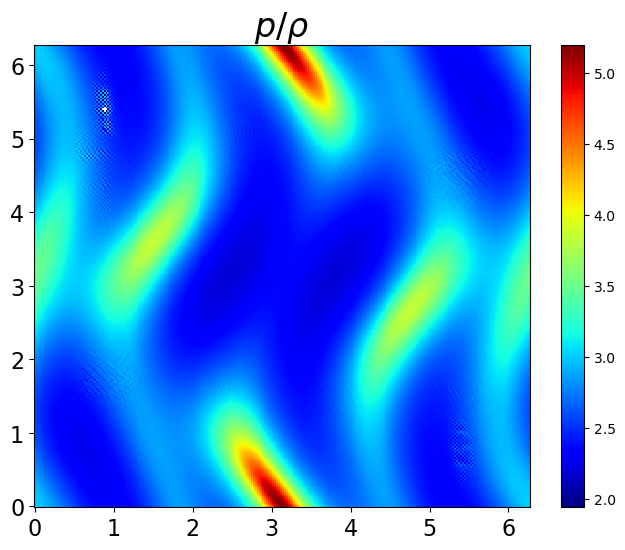

In [6]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)

rho = U[0, :, :]
u = U[1, :, :] / rho 
v = U[2, :, :] / rho 
w = U[3, :, :] / rho 
Bx = U[4, :, :]
By = U[5, :, :]
Bz = U[6, :, :]
e = U[7, :, :]
p = (gamma-1) * (e - rho*(u**2+v**2+w**2)/2 - (Bx**2+By**2+Bz**2)/2)
magnetic_pressure = 1/2 * (Bx**2+By**2+Bz**2)
pT = p + magnetic_pressure

contour = ax1.pcolormesh(X, Y, rho.T, cmap='jet')
cbar = plt.colorbar(contour, ax=ax1)

ax1.set_title(r"$p/\rho$", fontsize=24)
ax1.tick_params(labelsize=16)

plt.show()